In [ ]:
# Run if you want to get rid of water, leave only protein and make the molecules whole
! echo 1 | gmx trjconv -f ../dynamic.xtc -s ../dynamic.tpr -o vars/unwrapped_no_water.xtc -pbc nojump # make the molecules whole again!
! echo 1 | gmx trjconv -f ../dynamic.gro -s ../dynamic.tpr -o vars/unwrapped_no_water.gro -pbc nojump

cat: write error: Broken pipe
               :-) GROMACS - gmx trjconv, 2024.2-conda_forge (-:

Executable:   /opt/conda/envs/gromacs/bin.AVX2_256/gmx
Data prefix:  /opt/conda/envs/gromacs
Working dir:  /home/alexeyk/Desktop/simulations/Finished/serf_peg
Command line:
  gmx trjconv -f dynamic.xtc -s dynamic.tpr -o unwrapped_no_water.xtc -pbc nojump

Note that major changes are planned in future for trjconv, to improve usability and utility.
Will write xtc: Compressed trajectory (portable xdr format): xtc
Reading file dynamic.tpr, VERSION 2024.2-conda_forge (single precision)
Reading file dynamic.tpr, VERSION 2024.2-conda_forge (single precision)
Select group for output
Group     0 (         System) has 230186 elements
Group     1 (        Protein) has  6450 elements
Group     2 (      Protein-H) has  6450 elements
Group     3 (        C-alpha) has     0 elements
Group     4 (       Backbone) has     0 elements
Group     5 (      MainChain) has     0 elements
Group     6 (   MainChain+C

In [1]:
import MDAnalysis as mda
import numpy as np
# Load the simulation files

u= mda.Universe("vars/unwrapped_no_water.gro", "vars/unwrapped_no_water.xtc")

NUM_RES = 59
NUM_PROTEINS = 50
PROTEIN_LEN = 129

proteins = []

# this selects all 50 atoms
for i in range(NUM_PROTEINS):
    max_atoms = NUM_PROTEINS * PROTEIN_LEN
    start_index = i * PROTEIN_LEN + 1
    end_index = (i + 1) * PROTEIN_LEN
    proteins.append(u.select_atoms(f"bynum {start_index}:{end_index}"))

[    0.            46.46657776    92.01586847 ... 34970.47459204
 35066.12741685 35263.89234188]


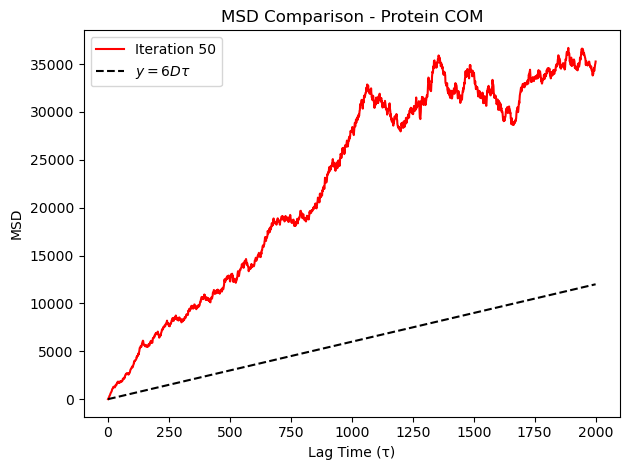

In [2]:
from MDAnalysis.lib.distances import distance_array
import numpy as np
import matplotlib.pyplot as plt

msd = np.zeros(len(u.trajectory)) # preallocate array

references = []
u.trajectory[0]
for protein in proteins:
    references.append(protein.center_of_mass())

for frame, ts in enumerate(u.trajectory):
    msd_per_frame = 0
    for i, protein in enumerate(proteins):
        prot = protein.center_of_mass()
        msd_per_frame += (prot[0]-references[i][0])**2 + (prot[1]-references[i][1])**2 +(prot[2]-references[i][2])**2
    msd_per_frame = msd_per_frame/NUM_PROTEINS
    msd[frame] = msd_per_frame
    
print(msd)


n_frames = len(u.trajectory)
fig, ax = plt.subplots() 
# Plot the current iteration
ax.plot(
    [i for i in range(n_frames)], 
    msd, 
    label=f'Iteration {i + 1}', 
    linestyle="-", 
    color="red"
)

timestep = 1
lagtimes2 = np.arange(n_frames) * timestep

# Plot the exact result for comparison
exact = lagtimes2 * 6  # Replace with the actual expected result
ax.plot(lagtimes2, exact, color="black", linestyle="--", label=r'$y=6D\tau$')

# Add labels, legend, and show plot
ax.set_xlabel("Lag Time (τ)")
ax.set_ylabel("MSD")
ax.legend(loc='upper left')
ax.set_title(f"MSD Comparison - Protein COM")
plt.tight_layout()  # Adjust layout for better spacing
plt.show()  # Display the plot for this iteration
        

In [ ]:
#!gmx msd -f output_no_water.xtc -s output_no_water.gro -n index.ndx -o msd.xvg -mol
!gmx msd -f vars/unwrapped_no_water.xtc -s vars/unwrapped_no_water.gro -o vars/msd.xvg -mol -trestart 2000

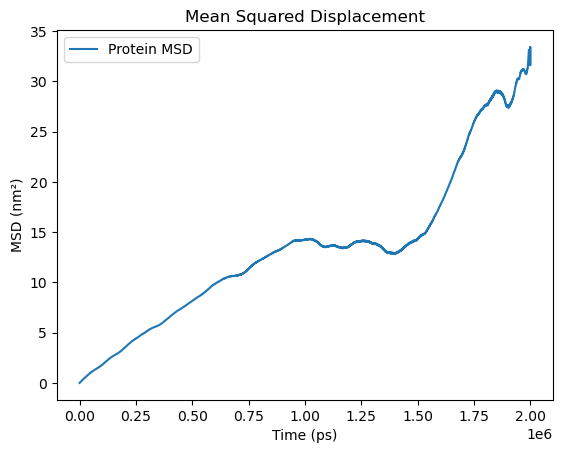

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Load MSD data
data = np.loadtxt("vars/msd.xvg", comments=["@", "#"])

# Extract columns
time = data[:, 0]  # Time in ps
msd = data[:, 1]   # MSD in nm²

# Plot the data
plt.plot(time, msd, label="Protein MSD")
plt.xlabel("Time (ps)")
plt.ylabel("MSD (nm²)")
plt.title("Mean Squared Displacement")
plt.legend()
plt.show()

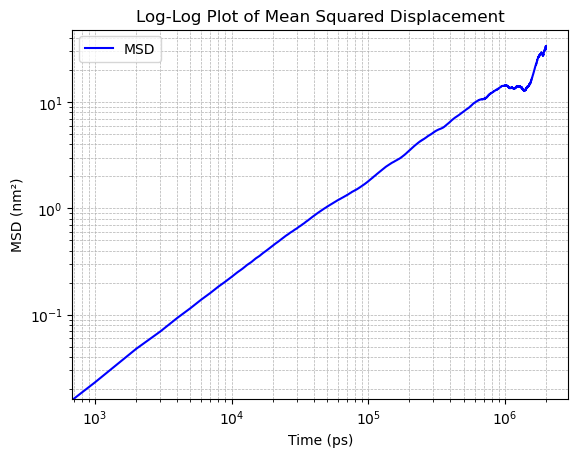

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Load data from the MSD output file (replace with your actual file path)
data = np.loadtxt("vars/msd.xvg", comments=["@", "#"])

# Extract columns
time = data[:, 0]  # Time in ps
msd = data[:, 1]   # MSD in nm²

# Create a log-log plot
plt.figure()
plt.loglog(time, msd, label="MSD", color="blue", linestyle="-")

# Add labels, title, and legend
plt.xlabel("Time (ps)")
plt.ylabel("MSD (nm²)")
plt.title("Log-Log Plot of Mean Squared Displacement")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)  # Add gridlines
plt.show()